# TCLab CLP - PID - FF

### Imports

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from matplotlib import colors as mcolors
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display, clear_output
import tclab
from datetime import datetime
import time
import os

from package_DBR import myRound, SelectPath_RT, Delay_RT, FO_RT, FOPDT, SOPDT, FOPDT_cost, SOPDT_cost, Process, Bode

import package_LAB
from importlib import reload
package_LAB = reload(package_LAB)
from package_LAB import LeadLag_RT, PID_RT, IMC_Tuning, Controller


### Simulation parameters

In [18]:

#Simulation
TSim = 2500
Ts = 1
N = int(TSim/Ts) + 1

#Working point
MV0 = 50
DV0 = 50
PV0 = 60.5

#Process
#-------
#Parameters for input-output dynamics
Kp = 0.35711258020523884
T1p = 140.00376928937064
T2p = 7.922782664796644
thetap = 7.3555801756095915

#Parameters for disturbance dynamics
Kd = 0.3412336672067159
T1d = 189.99702702740825
T2d = 21.759406076826345
thetad = 18.21683345312439

#Parameter PID controller
gamma = 1

#IMC tuning
#-----------
P = Process({})
P.parameters['Kp'] = Kp
P.parameters['Tlead1'] = 0
P.parameters['Tlag1'] = T1p
P.parameters['Tlag2'] = T2p
P.parameters['theta'] = thetap
P.parameters['nInt'] = 0

C = Controller({})
IMC_Tuning(P,C,gamma)
Kc = C.parameters['Kc']
Ti = C.parameters['Ti']
Td = C.parameters['Td']


alpha = 1
MVMin = 0
MVMax = 100

### Simulation input signals

In [19]:
#simulation input signals
simulation= 4

if simulation == 1:
    # Scenario 1: OLP + no FF
    ManPath = {0: True, TSim: True}
    MVManPath = {0: MV0, TSim: MV0}
    SPPath = {0: PV0, TSim :PV0}
    DVPath = {0: 50.0, 1300: 60, TSim: 60.0}
    ActivateFF = False
    ManFF = True
    Title_loop = "Open-Loop"
    Title_FF = "No FeedForward"

elif simulation == 2:
    # Scenario 2: OLP + FF
    ManPath = {0: True, TSim: True}
    MVManPath = {0: MV0, TSim: MV0}
    SPPath = {0: PV0, TSim :PV0}
    DVPath = {0: 50.0, 1300: 60, TSim: 60.0}
    ActivateFF = True
    ManFF = True
    Title_loop = "Open-Loop"
    Title_FF = "FeedForward"

elif simulation == 3:
    # Scenario 3: CLP + no FF
    ManPath = {0: True, 500: False, TSim: False}
    MVManPath = {0: MV0+15, TSim: MV0+15}
    SPPath = {0: PV0+5, 1200: PV0-5, TSim :PV0-5}
    DVPath = {0: DV0, 1700: DV0+10, TSim: DV0+10}
    ActivateFF = False
    ManFF = False 
    Title_loop = "Closed-Loop"
    Title_FF = "No FeedForward"

elif simulation == 4:
    #Scenario 4 : CLP + FF
    ManPath = {0:True, 500:False, TSim: False}
    MVManPath = {0:MV0+15, TSim:MV0+15}
    SPPath = {0:PV0+5, 1400: PV0-5, TSim: PV0-5}
    DVPath = {0:DV0, 1900: DV0+10, TSim: DV0+10}
    ActivateFF = True
    ManFF = False 
    Title_loop = "Closed-loop"
    Title_FF = "FeedForward"

else :
    ManPath = {0:True, 500:False, TSim: False}
    MVManPath = {0:MV0+15, TSim:MV0+15}
    SPPath = {0:PV0+5, 1400: PV0-5, TSim: PV0-5}
    DVPath = {0:DV0, 1900: DV0+10, TSim: DV0+10}
    ActivateFF = True
    ManFF = False 
    Title_loop = "Closed-loop"
    Title_FF = "FeedForward"

### Closed-loop simulation with PID and FF

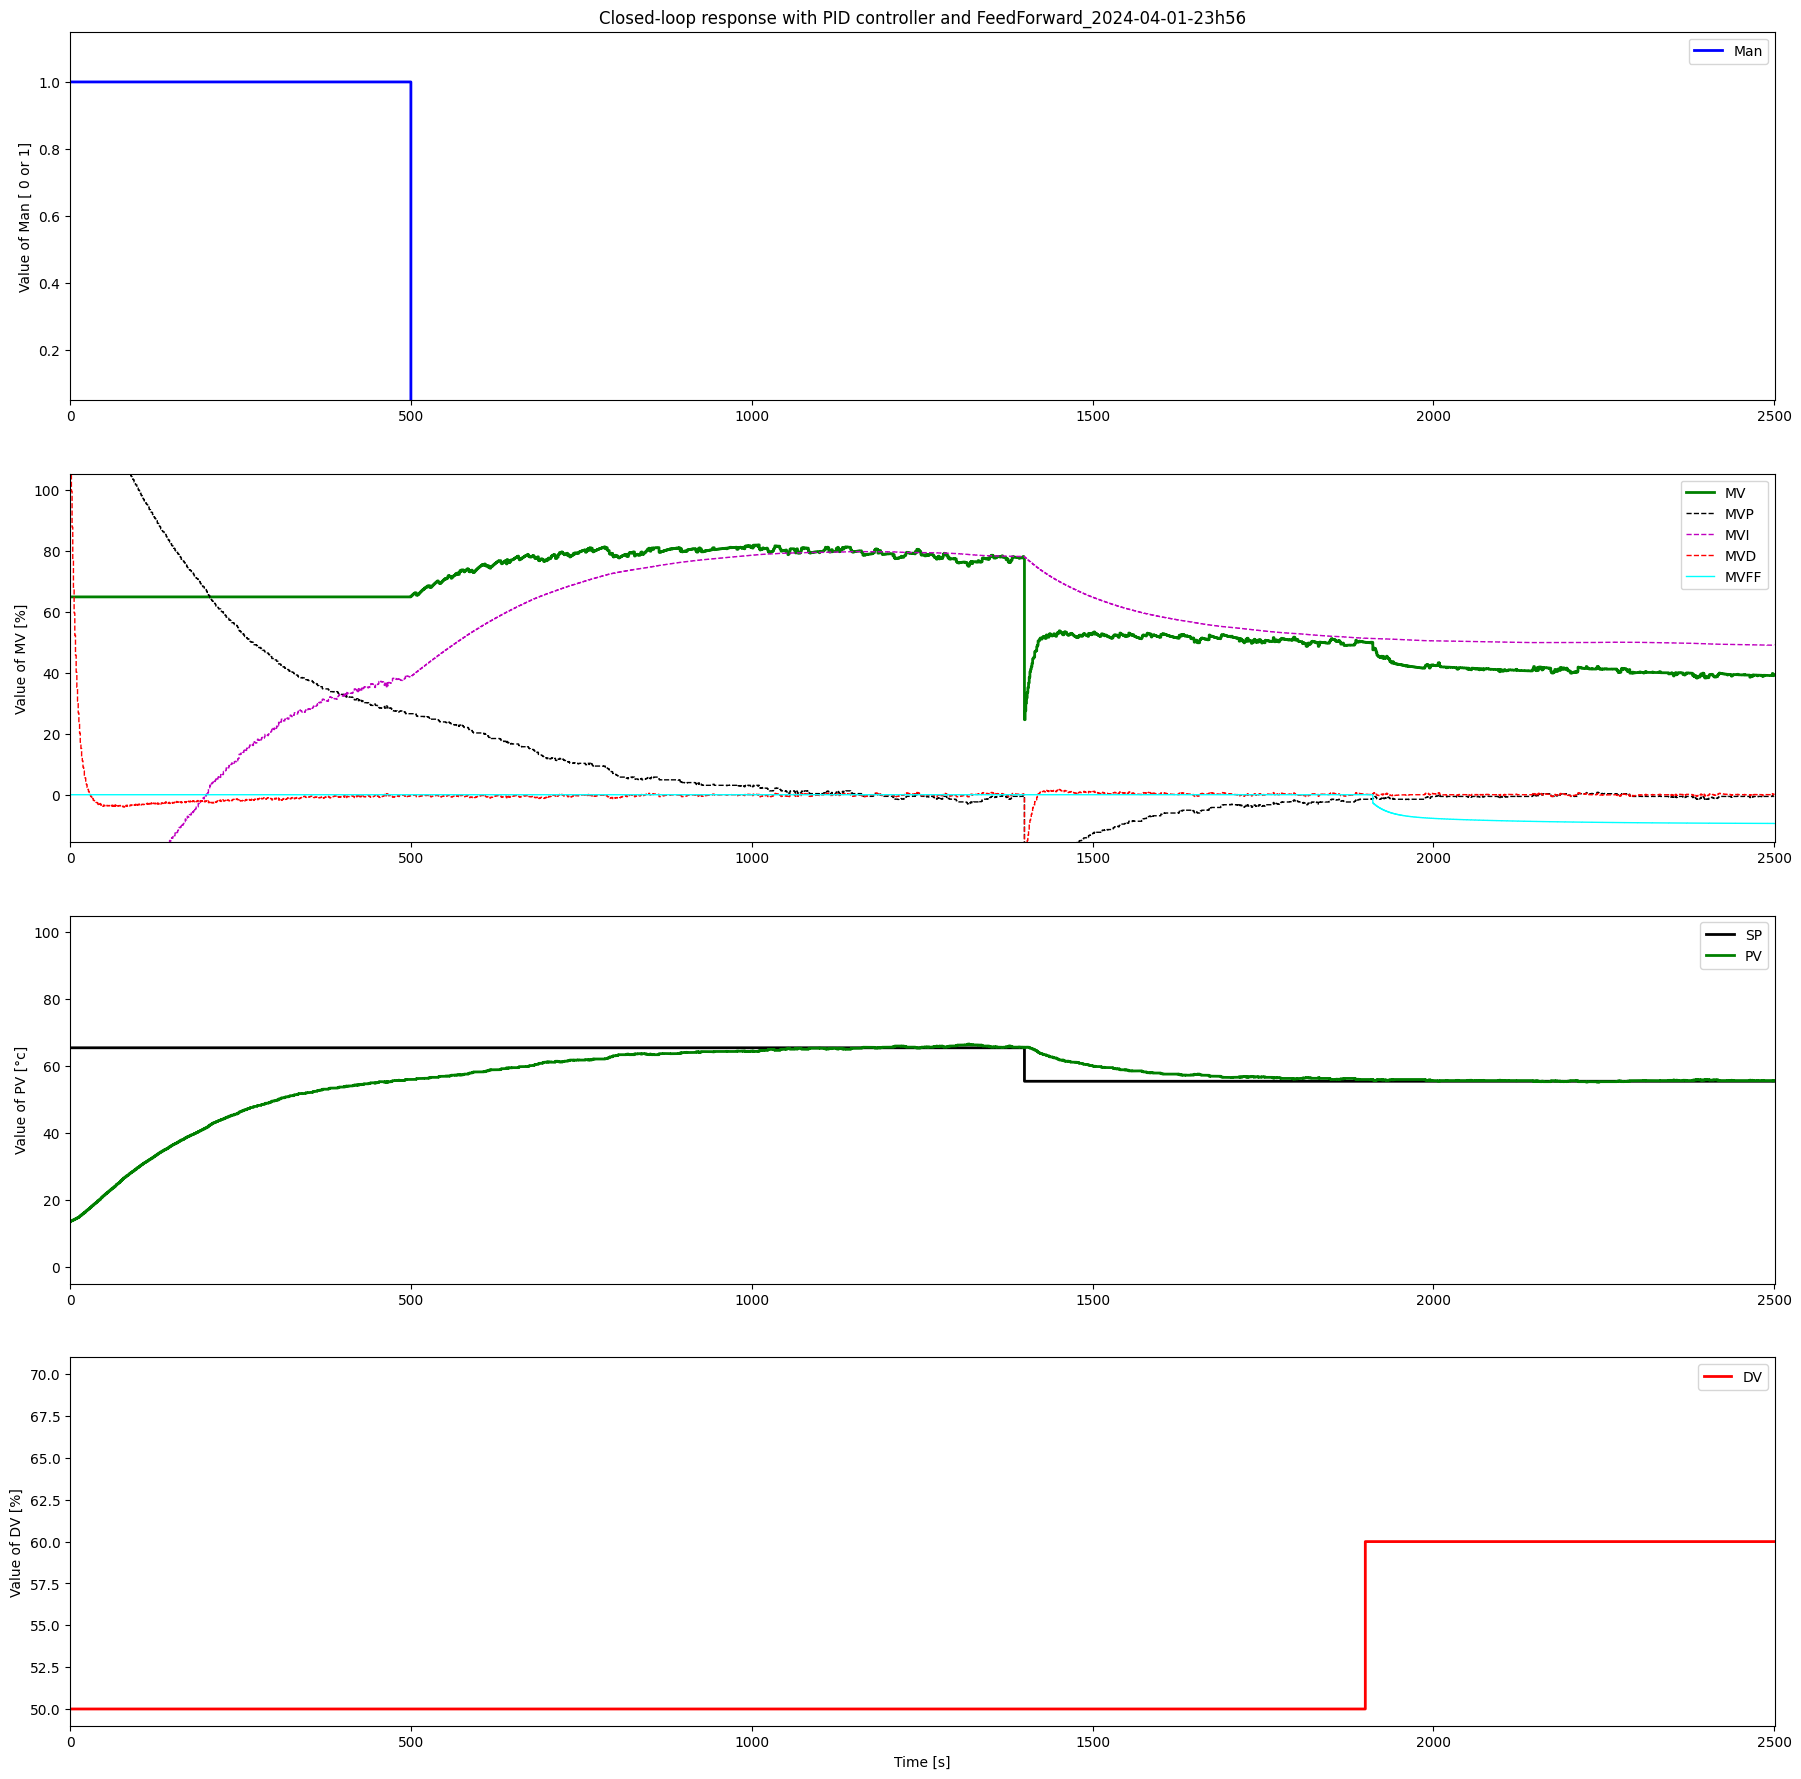

TCLab disconnected successfully.


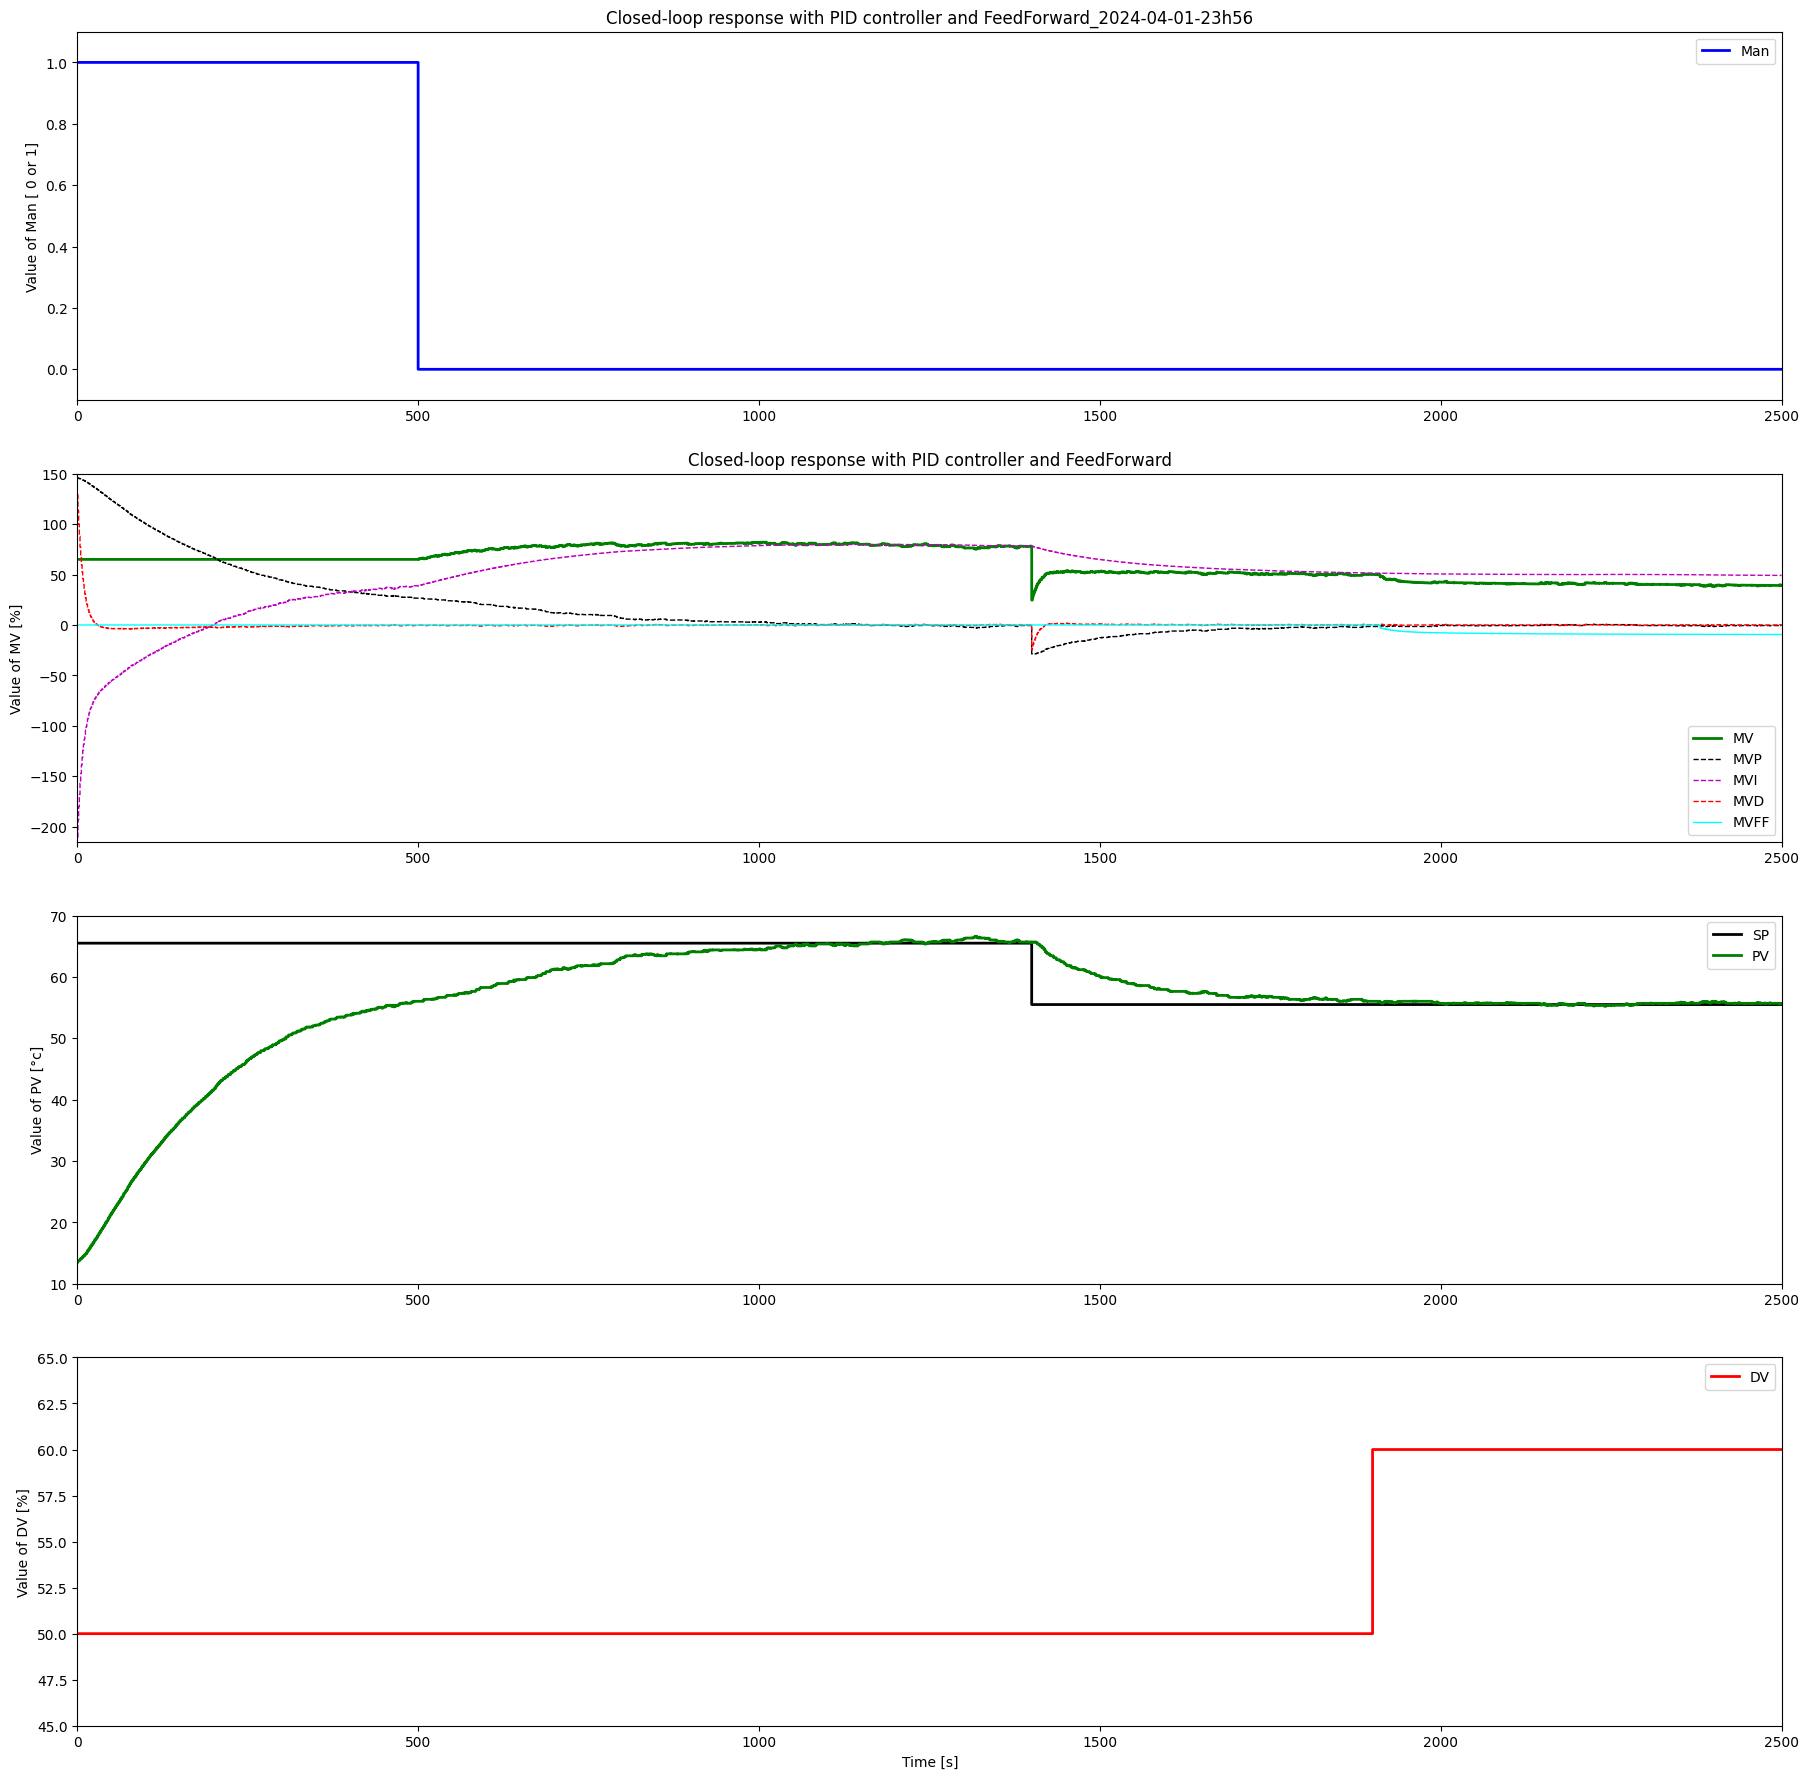

In [20]:


t = []
SP = []
MV = []
PV = []
DV =[]
Man = []
MVMan = []
MVFF = []
MVP = []
MVI = []
MVD = [] 
E  = []
EP = []
ED = []

MVFFDelay = []
MVFFLL1 = []

lab = tclab.TCLab()
 
now = datetime.now()
date_time = now.strftime("%Y-%m-%d-%Hh%M")

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1)
fig.set_figheight(22)
fig.set_figwidth(22)

l1, = ax1.step([0,TSim],[0.1,1.1],'b-',linewidth=2,label='Man',where='post')
ax1.set_ylabel('Value of Man [ 0 or 1]')
ax1.set_title(Title_loop + ' response with PID controller and ' + Title_FF + '_' + date_time)
ax1.legend(loc='best')

l2, = ax2.step([0,TSim],[-10,100],'g-',linewidth=2,label='MV',where='post')
l3, = ax2.step([0,TSim],[-10,100],'k--',linewidth=1,label='MVP',where='post')
l4, = ax2.step([0,TSim],[-10,100],'m--',linewidth=1,label='MVI',where='post')
l5, = ax2.step([0,TSim],[-10,100],'r--',linewidth=1,label='MVD',where='post')
l9, = ax2.step([0,TSim],[-10,100],'cyan',linewidth=1,label='MVFF',where='post')
ax2.set_ylabel('Value of MV [%]')
ax2.legend(loc='best')

l6, = ax3.step([0,TSim],[0,100],'k-',linewidth=2,label='SP',where='post')
l7, = ax3.step([0,TSim],[0,100],'g-',linewidth=2,label='PV',where='post')
ax3.set_ylabel('Value of PV [°c]')
ax3.legend(loc='best')

l8, = ax4.step([0,TSim],[50,70],'r',linewidth=2,label='DV',where='post')
ax4.set_xlabel('Time [s]')
ax4.set_ylabel('Value of DV [%]')
ax4.legend(loc='best')


for i in range(0, N):
    t.append(i*Ts)

    if t[-1] == 0:
        last_time = time.time()
    
    #PV value
    PV.append(lab.T1)
    
    
    #input signal SP and DV
    SelectPath_RT(SPPath,t,SP)
    SelectPath_RT(DVPath,t,DV)

    # DV applied to TClab
    lab.Q2(DV[-1])
    
    #Feedforward
    Delay_RT(DV - DV0*np.ones_like(DV),np.max([thetad-thetap,0]),Ts,MVFFDelay)
    LeadLag_RT(MVFFDelay, -Kd/Kp, T1p,T1d,Ts,MVFFLL1)
    if ActivateFF:
        LeadLag_RT(MVFFLL1, 1, T2p,T2d,Ts,MVFF)
    else:
        LeadLag_RT(MVFFLL1, 0, T2p,T2d,Ts,MVFF)
        
    #PID controller mode
    SelectPath_RT(ManPath,t,Man)
    SelectPath_RT(MVManPath,t,MVMan)
    
    #PID control action
    PID_RT(SP,PV,Man,MVMan,MVFF,Kc,Ti,Td,alpha,Ts,MVMin,MVMax,MV,MVP,MVI,MVD,E,ManFF,PV0,method='EBD-EBD')

    # MV applied to TClab
    lab.Q1(MV[-1])
    print(MV[-1])
    print(PV[-1])
    print(DV[-1])


    #wait for sampling period Ts
    now = time.time()
    delta = now - last_time

    time.sleep(np.max([0,Ts-delta]))
    last_time = time.time()

    
    l1.set_data(t,Man)
    l2.set_data(t,MV)
    l3.set_data(t,MVP)
    l4.set_data(t,MVI)
    l5.set_data(t,MVD)
    l6.set_data(t,SP)
    l7.set_data(t,PV)
    l8.set_data(t,DV)
    l9.set_data(t,MVFF)
    
    
    clear_output(wait=True)
    
    ax1.set_xlim(0, t[-1]+1)
    ax2.set_xlim(0, t[-1]+1)
    ax3.set_xlim(0, t[-1]+1)
    ax4.set_xlim(0, t[-1]+1)

    clear_output(wait=True)
    
    ax1.set_xlim(0, t[-1]+1)
    ax2.set_xlim(0, t[-1]+1)
    ax3.set_xlim(0, t[-1]+1)
    ax4.set_xlim(0, t[-1]+1)

    display(fig)
    
lab.close()


#save plot
now = datetime.now()
date_time = now.strftime("%Y-%m-%d-%Hh%M")
ax1.set_ylim(-0.1,1.1)
ax2.set_title(Title_loop + ' response with PID controller and ' + Title_FF)
ax2.set_ylim(myRound(np.min((np.min(MV),np.min(MVP),np.min(MVI),np.min(MVD),np.min(MVFF))),5)-5, myRound(np.max((np.max(MV),np.max(MVP),np.max(MVI),np.max(MVD),np.max(MVFF))),5)+5)
ax3.set_ylim(myRound(np.min((np.min(PV),np.min(SP))),5)-5,myRound(np.max((np.max(PV),np.max(SP))),5)+5)
ax4.set_ylim(myRound(np.min(DV),5)-5,myRound(np.max(DV),5)+5)

# save Data

t = np.array(t)
MV = np.array(MV)
MVP = np.array(MVP)
MVI = np.array(MVI)
MVD = np.array(MVD)
MVFF = np.array(MVFF)
SP = np.array(SP)
PV = np.array(PV)
DV = np.array(DV)
Man = np.array(Man)
my_data = np.vstack((t.T,MV.T,MVP.T,MVI.T,MVD.T,MVFF.T,SP.T,PV.T,DV.T,Man.T))
my_data = my_data.T
nameFile = 'Data/TCLab_CLP_PID_FF_experiment' +'_'+ date_time + '.txt'
if not os.path.exists('Data'):
    os.makedirs('Data')
np.savetxt(nameFile,my_data,delimiter=',',header='t,MV,MVP,MVI,MVD,MVFF,SP,PV,DV',comments='')  


# Save Plot
# ---------
if not os.path.exists('Plots'):
    os.makedirs('Plots')

titleName = 'TCLab_CLP_PID_FF_experiment' + '_' + date_time
plt.savefig('Plots\\' + titleName + '.png',transparent=True)
plt.savefig('Plots\\' + titleName + '.pdf',transparent=True)
    
    